In [1]:
import copy
import sys
import os


# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R, lapse_dry
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots, fig_resize, update_fontsize, update_linewidth
from isca_tools.thesis.adiabat_theory2 import get_scale_factor_theory
from isca_tools.thesis.lapse_theory import interp_var_at_pressure, get_bulk_lapse_rate, reconstruct_temp
from isca_tools import cesm
from isca_tools.convection.base import lcl_metpy
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from geocat.comp.interpolation import interp_hybrid_to_pressure
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['T', 'PS', 'QREFHT', 'TREFHT', 'Z3']
var_isca_dict = {'T': 'temp', 'PS': 'ps', 'QREFHT': 'sphum_2m', 'TREFHT': 'temp_2m', 'Z3': 'height'}

use_time_start = 3      # ignore the first two years

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'
is_isca_data = 'cesm' not in 'exp_dir'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}_2m", f"k={str(tau_lw_warm).replace('.','_')}_2m"]
# kappa_names = kappa_names[:1]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j], decode_times=True)
        ds_use = ds_use.sel(time=ds_use.time.dt.year >= use_time_start)
        if is_isca_data:
            # Rename isca data to same as for CESM
            ds_use = ds_use[[var_isca_dict[key] for key in var_keep]]
            ds_use = ds_use.rename_vars({v: k for k, v in var_isca_dict.items()})
        else:
            ds_use = ds_use[var_keep]
        ds += [ds_use]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        if j==0:
            p0 = float(namelist['spectral_dynamics_nml']['reference_sea_level_press'])
            sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
            hybm = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')       # sigma levels corresponding to pressure levels
            hyam = np.zeros_like(hybm)
        pbar.update(1)

pfull = ds_use.pfull
n_pressure = ds[0].pfull.size

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 25 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


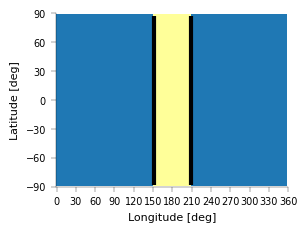

In [3]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
# changed name of this dataset to '_2m' so need to account for this here
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0].replace('_2m', ''), 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1)
    fig_resize(fig, 3)
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land

    if save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf")

In [29]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
region = 'extratropics'
lat_min = 40
lat_max = 65
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]}

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]


ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory

        # if is_land_data:
        #     # if not aquaplanet, then is land and only consider land longitudes
        #     ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])

        if season == 'summer':
            ds_nh_summer = ds_use.sel(time=ds_use.time.dt.month.isin(season_months['nh'])).sel(lat=slice(0, 90))
            ds_sh_summer = ds_use.sel(time=ds_use.time.dt.month.isin(season_months['sh'])).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        # ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use]
        pbar.update(1)
ds_all = xr.concat(ds_all, dim=xr.DataArray(tau_lw, dims="kappa", name="kappa"))
if is_isca_data:
    ds_all = ds_all.rename({'pfull': 'lev'})            # rename pfull as lev so same as cesm
ds_all = ds_all.load()

  0%|          | 0/2 [00:00<?, ?it/s]

In [30]:
# Interpolate onto pressure value desired for FT
pressure_ft = 400 * 100
# Compute T500 and Z500 from pressure info
ds_all['T_ft'] = interp_hybrid_to_pressure(ds_all.T, ds_all.PS, xr.DataArray(hyam, dims='lev'),
                                              xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(pressure_ft), lev_dim='lev')
ds_all['Z_ft'] = interp_hybrid_to_pressure(ds_all.Z3, ds_all.PS, xr.DataArray(hyam, dims='lev'),
                                              xr.DataArray(hybm, dims='lev'), p0, np.atleast_1d(pressure_ft), lev_dim='lev')

In [31]:
ds_all['p_lcl'], ds_all['T_lcl'] = lcl_metpy(ds_all.TREFHT.fillna(0), ds_all.QREFHT.fillna(0), ds_all.PS.fillna(0))

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/metpy/calc/thermo.py:1403: RuntimeWarning: divide by zero encountered in log
  val = np.log(vapor_pressure / mpconsts.nounit.sat_pressure_0c)
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/metpy/calc/thermo.py:1404: RuntimeWarning: invalid value encountered in divide
  return mpconsts.nounit.zero_degc + 243.5 * val / (17.67 - val)


In [32]:
# Get environmental info on pressure levels from average profile
def get_Tp_at_lcl(ds_prof, p_lcl, p_surf):
    ds_interp = interp_var_at_pressure(ds_prof, p_lcl, p_surf, xr.DataArray(hyam, dims='lev'),
                                       xr.DataArray(hybm, dims='lev'), p0)
    return ds_interp.T, ds_interp.plev
ds_all['T_at_lcl'], ds_all['p_at_lcl'] = get_Tp_at_lcl(ds_all[['T']], ds_all.p_lcl.fillna(0), ds_all.PS.fillna(0))

ds_all['lapse_below_lcl'] = get_bulk_lapse_rate(ds_all.TREFHT, ds_all.T_at_lcl, ds_all.PS, ds_all.p_at_lcl) * 1000
ds_all['lapse_above_lcl'] = get_bulk_lapse_rate(ds_all.T_at_lcl, ds_all.T_ft, ds_all.p_at_lcl, pressure_ft) * 1000

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/xarray/core/computation.py:825: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


In [33]:
def lat_band_average(da, lat_av_width):
    results = []
    lat_vals = da.lat.values

    for lat_center in lat_vals:
        # Select latitudes in the band
        band = da.sel(lat=(abs(da.lat - lat_center) <= lat_av_width))
        results.append(area_weighting(band).mean(dim=['lat', 'lon']))

    out = xr.concat(results, dim="lat")
    out["lat"] = lat_vals
    return out

In [34]:
lat_av_window = 1       # av over +/-1 1 latitude band either side of that considering, if less than 2.4 then just zonal av
ds_all['T_ft_spatial_av'] = lat_band_average(ds_all.T_ft, lat_av_window)
ds_all['T_ft_spatial_anom'] = ds_all['T_ft'] - ds_all['T_ft_spatial_av']
ds_all = ds_all.load()

/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/geocat/comp/interpolation.py:133: UserWarning: Interpolation point out of data bounds encountered
  return func_interpolate(new_levels, xcoords, data, axis=interp_axis)
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:160: RuntimeWarning: divide by zero encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])
/Users/joshduffield/miniforge3/envs/Isca/lib/python3.9/site-packages/metpy/interpolate/one_dimension.py:160: RuntimeWarning: invalid value encountered in divide
  var_interp = var[below] + (var[above] - var[below]) * ((x_array - xp[below])


In [35]:
# ds_all['lapse_above_lcl'] = ds_all['lapse_above_lcl'].transpose(..., 'lon')
# mask_surf = {'land': np.isin(ds_all.lon, np.unique(lon_land)), 'ocean': ~np.isin(ds_all.lon, np.unique(lon_land))}
# for surf in ['land']:
#     # plt.scatter(ds_all['TREFHT'].where(mask_surf[surf]), ds_all['T_ft_spatial_anom'].where(mask_surf[surf]), s=1, alpha=0.1,
#     #             c=ds_all['lapse_above_lcl'].isel(plev=0).where(mask_surf[surf]), vmin=4, vmax=8, cmap='viridis')
#     plt.scatter(ds_all['TREFHT'].where(mask_surf[surf]), ds_all['T_ft_spatial_anom'].where(mask_surf[surf]), s=1, alpha=0.1,
#                 c=(ds_all['T_ft_spatial_anom']*0 + ds_all['T_ft_spatial_av']).where(mask_surf[surf]))
#     # plt.scatter(ds_all['p_lcl'].where(mask_surf[surf]), ds_all['T_ft_spatial_anom'].where(mask_surf[surf]), s=1, alpha=0.1)

In [ ]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
quant_surf = 'ocean'                # Select surface to compute quantiles from
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant2 is the actual quantile value rather than the average above a given quantile
ds_quant3 = {'T': np.zeros((n_kappa, n_pressure, n_lat, n_quant)),
             'Z3': np.zeros((n_kappa, n_pressure, n_lat, n_quant))}
var_2d_list = ['PS', 'QREFHT', 'TREFHT', 'T_ft', 'Z_ft', 'p_lcl', 'T_lcl','p_at_lcl', 'T_at_lcl',
               'lapse_below_lcl', 'lapse_above_lcl', 'T_ft_spatial_av', 'T_ft_spatial_anom']
for key in var_2d_list:
    ds_quant3[key] = np.zeros((n_kappa, n_lat, n_quant))
    ds_quant3[key+'_std'] = np.zeros((n_kappa, n_lat, n_quant))


with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all.isel(kappa=j)
        ds_use = ds_use.isel(lon=mask_surf[quant_surf])
        ds_quant3['TREFHT'][j] = ds_use.TREFHT.quantile(quant_plot/100, dim=['lon', 'time'], keep_attrs=True).transpose()
        for k in range(n_lat):
            # only 1 plev, so select it here to remove it
            ds_use = ds_all.isel(kappa=j, lat=k, plev=0).isel(lon=mask_surf[quant_surf])
            ds_use['T_ft_spatial_av'] = ds_use.T_ft_spatial_anom * 0 + ds_use['T_ft_spatial_av']        # make have same dimensions as other 2d stuff
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.TREFHT, quant, 0.5, 0.5)
                ds_quant3['T'][j, :, k, q] = ds_use.T[:, use_ind].mean(dim='lon_time')
                ds_quant3['Z3'][j, :, k, q] = ds_use.Z3[:, use_ind].mean(dim='lon_time')
                for key in var_2d_list:
                    ds_quant3[key][j, k, q] = ds_use[key][use_ind].mean(dim='lon_time')
                    ds_quant3[key+'_std'][j, k, q] = ds_use[key][use_ind].std(dim='lon_time')
                pbar.update(1)

# Convert to dataset
coords = {"kappa": tau_lw, "lev": np.asarray(pfull)*100, "lat": ds_all.lat, "quant": quant_plot}
ds_quant3 = xr.Dataset({
    key: xr.DataArray(ds_quant3[key], dims=["kappa", "lev", "lat", "quant"] if key in ['T', 'Z3'] else ["kappa", "lat", "quant"],
                      coords=coords if key in ['T', 'Z3'] else {k: coords[k] for k in ["kappa", "lat", "quant"]}) for key in ds_quant3
})

  0%|          | 0/3564 [00:00<?, ?it/s]

In [37]:
def plot_with_std(ax, x, var, var_std, color='C0', alpha=0.2, label=None, ax_lat=0, lat_weights=lat_weights):
    var_min = var-var_std
    var_max = var+var_std
    if lat_weights is not None:
        var = np.average(var, axis=ax_lat, weights=lat_weights)
        var_min = np.average(var_min, axis=ax_lat, weights=lat_weights)
        var_max = np.average(var_max, axis=ax_lat, weights=lat_weights)
    ax.plot(x, var, color=color, label=label)
    ax.fill_between(x, var_min, var_max, color=color, alpha=alpha)

ax_linewidth = plt.rcParams['axes.linewidth']

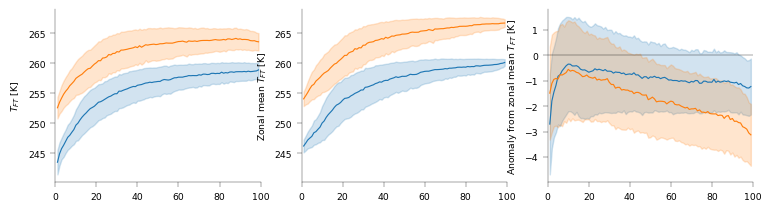

In [38]:
fig, ax = plt.subplots(1,3, sharex=True)
fig_resize(fig, 9)
for i in range(n_kappa):
    plot_with_std(ax[0], quant_plot, ds_quant3.T_ft.isel(kappa=i), ds_quant3.T_ft_std.isel(kappa=i), color=f'C{i}')
    plot_with_std(ax[1], quant_plot, ds_quant3.T_ft_spatial_av.isel(kappa=i), ds_quant3.T_ft_spatial_av_std.isel(kappa=i), color=f'C{i}')
    plot_with_std(ax[2], quant_plot, ds_quant3.T_ft_spatial_anom.isel(kappa=i), ds_quant3.T_ft_spatial_anom_std.isel(kappa=i), color=f'C{i}')
ax[0].sharey(ax[1])
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$T_{FT}$ [K]')
ax[1].set_ylabel('Zonal mean $T_{FT}$ [K]')
ax[2].set_ylabel('Anomaly from zonal mean $T_{FT}$ [K]')
update_fontsize(fig)
update_linewidth(fig)
ax[2].axhline(0, color='k', lw=ax_linewidth)
plt.show()

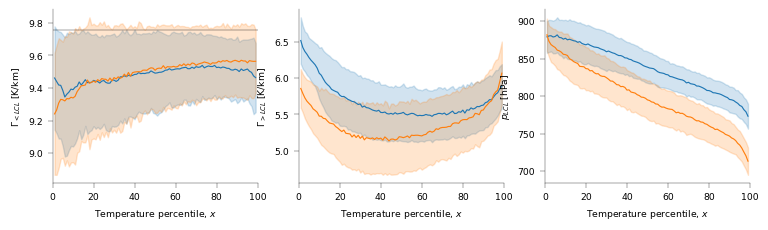

In [39]:
fig, ax = plt.subplots(1,3, sharex=True)
fig_resize(fig, 9)
for i in range(n_kappa):
    plot_with_std(ax[0], quant_plot, ds_quant3.lapse_below_lcl.isel(kappa=i), ds_quant3.lapse_below_lcl_std.isel(kappa=i), color=f'C{i}')
    plot_with_std(ax[1], quant_plot, ds_quant3.lapse_above_lcl.isel(kappa=i), ds_quant3.lapse_above_lcl_std.isel(kappa=i), color=f'C{i}')
    plot_with_std(ax[2], quant_plot, ds_quant3.p_at_lcl.isel(kappa=i)/100, ds_quant3.p_at_lcl_std.isel(kappa=i)/100, color=f'C{i}')

ax[0].set_ylabel('$\Gamma_{<LCL}$ [K/km]')
ax[1].set_ylabel('$\Gamma_{>LCL}$ [K/km]')
ax[2].set_ylabel('$p_{LCL}$ [hPa]')
ax[0].set_xlim(0, 100)
for i in range(len(ax)):
    ax[i].set_xlabel(percentile_label)
update_fontsize(fig)
update_linewidth(fig)
ax[0].axhline(lapse_dry*1000, color='k', lw=ax_linewidth, label='Dry')
plt.show()

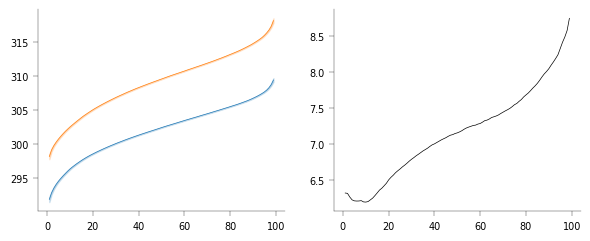

In [42]:
fig, ax = plt.subplots(1,2, sharex=True)
fig_resize(fig, 7)
for i in range(n_kappa):
    plot_with_std(ax[0], quant_plot, ds_quant3.TREFHT.isel(kappa=i), ds_quant3.TREFHT_std.isel(kappa=i), color=f'C{i}')
ax[1].plot(quant_plot, np.average(ds_quant3.TREFHT.isel(kappa=1)-ds_quant3.TREFHT.isel(kappa=0), axis=0, weights=lat_weights), color='k')
plt.show()